<a href="https://colab.research.google.com/github/Engineer-Ayesha-Shafique/Brain-Tumor-Segmentation-and-Detection-using-UNET-and-Watershed-in-Python/blob/main/Brain_Tumor_Segmentation_and_Detection_using_UNET_and_Watershed_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive' ,force_remount=True)

Mounted at /content/drive


#UNET

https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation


In [ ]:
!pip install tensorflow
!pip install --quiet segmentation-models tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
#!/usr/bin/env python3
"""
segformer_builder.py

Replace UNet builder with a SegFormer-based segmentation model.

Dependencies:
    pip install tensorflow transformers

Usage:
    from segformer_builder import build_segformer
    model, preprocessor = build_segformer(
        model_name='nvidia/segformer-b0-finetuned-ade-512-512',
        input_shape=(512,512,3),
        num_labels=5
    )
    model.summary()

"""
import tensorflow as tf
from transformers import SegformerFeatureExtractor, TFSegformerForSemanticSegmentation


def build_segformer(
    model_name: str,
    input_shape: tuple,
    num_labels: int,
    activation: str = 'softmax',
    trainable_backbone: bool = False
) -> tuple:
    """
    Builds a SegFormer segmentation model using Hugging Face Transformers in TensorFlow.

    Args:
        model_name: name of a pretrained SegFormer checkpoint (e.g. 'nvidia/segformer-b0-finetuned-ade-512-512').
        input_shape: (height, width, channels) of input images.
        num_labels: number of segmentation classes.
        activation: final activation to apply (e.g. 'softmax', 'sigmoid').
        trainable_backbone: whether to fine-tune the transformer encoder.

    Returns:
        model: a tf.keras.Model that accepts BGR uint8 images [0,255] and outputs class logits.
        preprocessor: a SegformerFeatureExtractor for input preprocessing.
    """
    # 1) Create the feature extractor for resizing and normalization
    preprocessor = SegformerFeatureExtractor(
        size={
            'height': input_shape[0],
            'width': input_shape[1]
        },
        do_reduce_labels=False,
        do_resize=True,
        do_normalize=True
    )

    # 2) Load pretrained SegFormer for semantic segmentation
    segformer = TFSegformerForSemanticSegmentation.from_pretrained(
        model_name,
        num_labels=num_labels,
        ignore_mismatched_sizes=True
    )

    # 3) Build a Keras wrapper
    inp = tf.keras.Input(shape=input_shape, dtype=tf.uint8, name='pixel_values')
    # preprocess: cast to float and normalize
    x = tf.cast(inp, tf.float32)
    x = x / 255.0

    outputs = segformer(pixel_values=x, training=False).logits  # shape: (batch, H, W, num_labels)

    out = tf.keras.layers.Activation(activation, name='segmentation')(outputs)

    model = tf.keras.Model(inputs=inp, outputs=out, name='segformer')

    if not trainable_backbone:
        for layer in model.layers:
            if layer.name.startswith('segformer'):  # HF layers prefixed
                layer.trainable = False

    return model, preprocessor


if __name__ == '__main__':
    NUM_CLASSES = 5
    INPUT_SHAPE = (512, 512, 3)
    MODEL_NAME = 'nvidia/segformer-b0-finetuned-ade-512-512'

    model, prep = build_segformer(
        model_name=MODEL_NAME,
        input_shape=INPUT_SHAPE,
        num_labels=NUM_CLASSES,
        activation='softmax',
        trainable_backbone=False
    )
    model.summary()


/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFSegformerForSemanticSegmentation: ['decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFSegformerForSemanticSegmentation were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.
Some w

ValueError: Exception encountered when calling layer "tf_segformer_for_semantic_segmentation" (type TFSegformerForSemanticSegmentation).

in user code:

    File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 964, in run_call_with_unpacked_inputs  *
        return func(self, **unpacked_inputs)
    File "/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/modeling_tf_segformer.py", line 994, in call  *
        outputs = self.segformer(
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filembpsv1q3.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/tmp/__autograph_generated_filegi5n0z9n.py", line 15, in tf__call
        encoder_outputs = ag__.converted_call(ag__.ld(self).encoder, (ag__.ld(pixel_values),), dict(output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_fileso4txneh.py", line 103, in tf__call
        ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.converted_call(ag__.ld(zip), (ag__.ld(self).embeddings, ag__.ld(self).block, ag__.ld(self).layer_norms), None, fscope),), None, fscope), None, loop_body_1, get_state_4, set_state_4, ('all_hidden_states', 'all_self_attentions', 'hidden_states'), {'iterate_names': '(idx, x)'})
    File "/tmp/__autograph_generated_fileso4txneh.py", line 27, in loop_body_1
        hidden_states, height, width = ag__.converted_call(ag__.ld(embedding_layer), (ag__.ld(hidden_states),), None, fscope)
    File "/tmp/__autograph_generated_filehvmbk3rw.py", line 11, in tf__call
        embeddings = ag__.converted_call(ag__.ld(self).proj, (ag__.converted_call(ag__.ld(self).padding, (ag__.ld(pixel_values),), None, fscope),), None, fscope)

    ValueError: Exception encountered when calling layer 'segformer' (type TFSegformerMainLayer).
    
    in user code:
    
        File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 964, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/modeling_tf_segformer.py", line 599, in call  *
            encoder_outputs = self.encoder(
        File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_fileso4txneh.py", line 103, in tf__call
            ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.converted_call(ag__.ld(zip), (ag__.ld(self).embeddings, ag__.ld(self).block, ag__.ld(self).layer_norms), None, fscope),), None, fscope), None, loop_body_1, get_state_4, set_state_4, ('all_hidden_states', 'all_self_attentions', 'hidden_states'), {'iterate_names': '(idx, x)'})
        File "/tmp/__autograph_generated_fileso4txneh.py", line 27, in loop_body_1
            hidden_states, height, width = ag__.converted_call(ag__.ld(embedding_layer), (ag__.ld(hidden_states),), None, fscope)
        File "/tmp/__autograph_generated_filehvmbk3rw.py", line 11, in tf__call
            embeddings = ag__.converted_call(ag__.ld(self).proj, (ag__.converted_call(ag__.ld(self).padding, (ag__.ld(pixel_values),), None, fscope),), None, fscope)
    
        ValueError: Exception encountered when calling layer 'encoder' (type TFSegformerEncoder).
        
        in user code:
        
            File "/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/modeling_tf_segformer.py", line 516, in call  *
                hidden_states, height, width = embedding_layer(hidden_states)
            File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/tmp/__autograph_generated_filehvmbk3rw.py", line 11, in tf__call
                embeddings = ag__.converted_call(ag__.ld(self).proj, (ag__.converted_call(ag__.ld(self).padding, (ag__.ld(pixel_values),), None, fscope),), None, fscope)
        
            ValueError: Exception encountered when calling layer 'patch_embeddings.0' (type TFSegformerOverlapPatchEmbeddings).
            
            in user code:
            
                File "/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/modeling_tf_segformer.py", line 94, in call  *
                    embeddings = self.proj(self.padding(pixel_values))
                File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
                File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
                    raise ValueError(
            
                ValueError: Input 0 of layer "proj" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 518, 9, 512)
            
            
            Call arguments received by layer 'patch_embeddings.0' (type TFSegformerOverlapPatchEmbeddings):
              • pixel_values=tf.Tensor(shape=(None, 512, 3, 512), dtype=float32)
        
        
        Call arguments received by layer 'encoder' (type TFSegformerEncoder):
          • pixel_values=tf.Tensor(shape=(None, 512, 3, 512), dtype=float32)
          • output_attentions=False
          • output_hidden_states=True
          • return_dict=True
          • training=False
    
    
    Call arguments received by layer 'segformer' (type TFSegformerMainLayer):
      • pixel_values=tf.Tensor(shape=(None, 512, 512, 3), dtype=float32)
      • output_attentions=False
      • output_hidden_states=True
      • return_dict=True
      • training=False


Call arguments received by layer "tf_segformer_for_semantic_segmentation" (type TFSegformerForSemanticSegmentation):
  • pixel_values=tf.Tensor(shape=(None, 512, 512, 3), dtype=float32)
  • labels=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None

In [ ]:
# install visualkeras for model plotting
!pip install --quiet visualkeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 23.2 MB/s eta 0:00:00


# Metrics

In [ ]:
import tensorflow as tf

smooth = 1e-15
num_classes = 5  # <-- make this match your final Conv2D(filters=5, ...)

def dice_coefficient(y_true, y_pred):
    # y_true: (B, H, W, 1) integers 0..4
    # y_pred: (B, H, W, 5) softmax probs

    # 1) Squeeze off the last dim → (B, H, W)
    y_true = tf.squeeze(y_true, axis=-1)

    # 2) One‑hot encode → (B, H, W, 5)
    y_true_o = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

    # 3) Flatten both to (B*H*W, 5)
    y_true_f = tf.reshape(y_true_o, [-1, num_classes])
    y_pred_f = tf.reshape(y_pred,   [-1, num_classes])

    # 4) Compute intersection & union per class
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union        = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)

    # 5) Dice per class, then average
    dice_per_class = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice_per_class)

def dice_coefficient_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)


#Train


In [ ]:
# In a notebook cell, before any cv2 imports:
!pip install --quiet opencv-python-headless
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# 1) Import TF first and set memory growth (fallback to experimental)
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as e:
            print(f"[GPU] Could not set memory growth: {e}")
    print(f"[GPU] Detected {len(gpus)} GPU(s).")

# 2) Now import the rest
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import (
    ModelCheckpoint, CSVLogger, ReduceLROnPlateau,
    EarlyStopping, TensorBoard
)
from tensorflow.keras.optimizers import Adam

""" Global parameters """
Height = 512
Width  = 512

def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path_dataset, val_ratio=0.2, test_ratio=0.1, random_state=42):
    img_dir  = os.path.join(path_dataset, "images")
    mask_dir = os.path.join(path_dataset, "masks")

    image_exts = ('.png', '.jpg', '.jpeg')
    images = sorted([
        os.path.join(img_dir, f)
        for f in os.listdir(img_dir)
        if f.lower().endswith(image_exts)
    ])


    mask_exts = ('.tif', '.tiff')
    masks = sorted([
        os.path.join(mask_dir, f)
        for f in os.listdir(mask_dir)
        if f.lower().endswith(mask_exts)
    ])

    if not images:
        raise RuntimeError(f"No images found in {img_dir}")
    if not masks:
        raise RuntimeError(f"No masks found in {mask_dir}")

    images_lookup = {
        os.path.splitext(os.path.basename(p))[0]: p
        for p in images
    }
#MildDemented_0a7b1321-eba0-40dc-85b8-de34241554a2_jpg.rf.70370fcd9ac0fb82f91d27f558053d84.tif
    pairs = []
    for m in masks:
        base = os.path.splitext(os.path.basename(m))[0]
        if base.endswith('_mask'):
            root = base[:-5]
            img_path = images_lookup.get(root)
            if img_path:
                pairs.append((img_path, m))

    if not pairs:
        raise RuntimeError("No matching image↔mask pairs found!")

    trainval, test = train_test_split(pairs, test_size=test_ratio, random_state=random_state)
    val_frac = val_ratio / (1.0 - test_ratio)
    train, val = train_test_split(trainval, test_size=val_frac, random_state=random_state)

    train_imgs, train_masks = zip(*train)
    val_imgs,   val_masks   = zip(*val)
    test_imgs,  test_masks  = zip(*test)

    return (
        list(train_imgs), list(train_masks),
        list(val_imgs),   list(val_masks),
        list(test_imgs),  list(test_masks)
    )

def read_image_file(path_img):
    path = path_img.decode('utf-8') if isinstance(path_img, bytes) else path_img
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (Width, Height)) / 255.0
    return img.astype(np.float32)

def read_mask_file(path_mask):
    path = path_mask.decode('utf-8') if isinstance(path_mask, bytes) else path_mask
    mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if mask.ndim == 3:
        mask = mask[..., 0]
    mask = cv2.resize(mask, (Width, Height), interpolation=cv2.INTER_NEAREST)

    # ✅ Clip to [0, 4], not [0, 3]:
    mask = np.clip(mask, 0, NUM_CLASSES-1)

    # Convert to integer class IDs
    mask = mask.astype(np.int32)

    # Add the channel dim back
    return mask[..., None]

def tf_parse(path_img, path_mask):
    # Tell numpy_function: img→float32, mask→int32
    img, mask = tf.numpy_function(
        lambda pi, pm: (read_image_file(pi), read_mask_file(pm)),
        [path_img, path_mask],
        [tf.float32, tf.int32]          # <-- second output is now int32
    )
    img.set_shape([Height, Width, 3])
    mask.set_shape([Height, Width, 1])
    return img, mask

def tf_dataset(inputs, targets, batch_size=2):
    ds = tf.data.Dataset.from_tensor_slices((inputs, targets))
    ds = ds.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

def edit_mask_images(mask_dir, func, output_dir=None):
    out_dir = output_dir or mask_dir
    create_folder(out_dir)
    exts = ('.tif')
    for fname in os.listdir(mask_dir):
        if not fname.lower().endswith(exts):
            continue
        in_path  = os.path.join(mask_dir, fname)
        mask     = cv2.imread(in_path, cv2.IMREAD_UNCHANGED)
        edited   = func(mask)
        cv2.imwrite(os.path.join(out_dir, fname), edited)
    print(f"[edit_mask_images] Applied edits to masks in {out_dir}")

if __name__ == "__main__":
    np.random.seed(42)
    tf.random.set_seed(42)

    create_folder("/content/drive/MyDrive/Project_41725/files")

    batch_size = 16
    lr         = 1e-4
    epochs_num     = 100
    path_model = os.path.join("/content/drive/MyDrive/Project_41725/files", "model.h5")
    path_csv   = os.path.join("/content/drive/MyDrive/Project_41725/files", "log.csv")

    ds_path = "/content/drive/MyDrive/Project_41725/newdata/train_maskimg"
    train_imgs, train_masks, val_imgs, val_masks, test_imgs, test_masks = load_dataset(ds_path)

    print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    train_ds = tf_dataset(train_imgs, train_masks, batch_size=batch_size)
    val_ds   = tf_dataset(val_imgs,   val_masks,   batch_size=batch_size)
    test_ds  = tf_dataset(test_imgs,  test_masks,  batch_size=batch_size)

    # Build, compile and fit your model below:
    # model = Unet_model((Height, Width, 3))
    # model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coeff])
    # callbacks = [ModelCheckpoint(...), ...]
    # model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)


[GPU] Detected 1 GPU(s).
Train: 24, Val: 7, Test: 4


In [ ]:
import os
import cv2
import numpy as np

# TODO: update this to your actual masks directory
mask_dir = "/content/drive/MyDrive/Project_41725/newdata/train_maskimg/masks"

# Gather all .tif/.tiff files
mask_files = [
    f for f in os.listdir(mask_dir)
    if f.lower().endswith(('.tif', '.tiff'))
]

print(f"Found {len(mask_files)} mask files in:\n  {mask_dir}\n")

suffix_count = 0

for fname in sorted(mask_files):
    path = os.path.join(mask_dir, fname)
    mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if mask is None:
        print(f"[ERROR] Could not read {fname}")
        continue

    stem = os.path.splitext(fname)[0]
    has_mask_suffix = stem.endswith("_mask")
    suffix_count += int(has_mask_suffix)

    unique_vals = np.unique(mask)
    print(
        f"{fname} | stem='{stem}' | '_mask' suffix? {has_mask_suffix} | "
        f"unique labels: {list(unique_vals)}"
    )

print(
    f"\nSummary:\n"
    f"  With '_mask' suffix: {suffix_count}\n"
    f"  Without suffix:      {len(mask_files) - suffix_count}"
)


Found 1738 mask files in:
  /content/drive/MyDrive/Project_41725/newdata/train_maskimg/masks

MildDemented_00be34e4-c61c-45a8-8ee8-48e29a8adce0_jpg.rf.bc8e786abf4ec687946d6ebbbe11300e_mask.tif | stem='MildDemented_00be34e4-c61c-45a8-8ee8-48e29a8adce0_jpg.rf.bc8e786abf4ec687946d6ebbbe11300e_mask' | '_mask' suffix? True | unique labels: [np.uint8(0), np.uint8(4)]
MildDemented_01bb5650-386e-4bdd-854e-54e12030a3c0_jpg.rf.91288ed2e7955c1255997e31afe67b6f_mask.tif | stem='MildDemented_01bb5650-386e-4bdd-854e-54e12030a3c0_jpg.rf.91288ed2e7955c1255997e31afe67b6f_mask' | '_mask' suffix? True | unique labels: [np.uint8(0), np.uint8(4)]
MildDemented_01dc8d82-81d9-4344-a80e-cf981232df36_jpg.rf.f1975ff08e1b64dba4100aafd50aa3aa_mask.tif | stem='MildDemented_01dc8d82-81d9-4344-a80e-cf981232df36_jpg.rf.f1975ff08e1b64dba4100aafd50aa3aa_mask' | '_mask' suffix? True | unique labels: [np.uint8(0), np.uint8(4)]
MildDemented_02addcbc-619b-4a93-bca0-fb21e0ab7066_jpg.rf.5b10a3fa0c4f10c0b6cf689bf9766e1c_mask.t

KeyboardInterrupt: 

In [ ]:
for msk in train_masks:
    arr = cv2.imread(msk, cv2.IMREAD_UNCHANGED)
    if arr is None: continue
    if np.any(arr > 3):
        print("[INVALID]", msk, np.unique(arr))


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
)
from tensorflow.keras.models import load_model

# Hyper‑params & paths
NUM_CLASSES = 5
INPUT_SHAPE = (512, 512, 3)
EPOCHS      = 160
path_model  = "/content/drive/MyDrive/Project_41725/files/model.h5"
path_csv    = "/content/drive/MyDrive/Project_41725/files/log.csv"

# 0) kill any existing graph/state
tf.keras.backend.clear_session()

# 1) rebuild
model = build_unet(backbone_name='efficientnetb4', input_shape=(512,512,3), n_classes=5)

# 2) override its internal name (strip out the '+')
model._name = "unet"

# 3) Define losses & metrics
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.squeeze(y_true, axis=-1)
    y_true_o = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)
    y_true_f = tf.reshape(y_true_o, [-1, NUM_CLASSES])
    y_pred_f = tf.reshape(y_pred,   [-1, NUM_CLASSES])
    inter = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denom = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)
    dice_per_class = (2. * inter + smooth) / (denom + smooth)
    return tf.reduce_mean(dice_per_class)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    ce = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    return ce + dice_loss(y_true, y_pred)

class MeanIoUArgMax(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=NUM_CLASSES, name="mean_iou", dtype=None):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.squeeze(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# 4) Compile
model.compile(
    optimizer=Adam(1e-4),
    loss=combined_loss,
    metrics=[dice_coef, MeanIoUArgMax()]
)


# 5) Callbacks
callbacks = [
    ModelCheckpoint(path_model, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(path_csv , append=False),
    EarlyStopping(monitor='val_loss', patience=20),
]

# 6) (Optional) Evaluate before training
print("Before training:", dict(zip(model.metrics_names, model.evaluate(test_ds))))

# 7) Fit
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)
# 6) Inference & metric collection
EVL_SCORE_list = []
for batch_images, batch_masks in test_ds:
    preds = model.predict(batch_images)
    # for each sample in the batch:
    for i in range(len(preds)):
        y_true = batch_masks[i].numpy().squeeze(-1)
        y_pred = np.argmax(preds[i], axis=-1)
        # compute F1, Jaccard, etc. (use sklearn.metrics)
        f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='macro', zero_division=0)
        j  = jaccard_score(y_true.flatten(), y_pred.flatten(), average='macro', zero_division=0)
        r  = recall_score(y_true.flatten(), y_pred.flatten(), average='macro', zero_division=0)
        p  = precision_score(y_true.flatten(), y_pred.flatten(), average='macro', zero_division=0)
        img_name = "batch{}_idx{}".format(batch_index, i)  # or however you track filenames
        EVL_SCORE_list.append((img_name, f1, j, r, p))

# 7) Save per-image metrics
df_scores = pd.DataFrame(EVL_SCORE_list,
                         columns=["Image","F1","Jaccard","Recall","Precision"])
os.makedirs(os.path.dirname(score_csv), exist_ok=True)
df_scores.to_csv(score_csv, index=False)
print("Wrote", score_csv)


KeyboardInterrupt: 

#Test


In [ ]:
from google.colab import drive
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files

# 1) Csv
import pandas as pd

# suppose you build EVL_SCORE_list as [(img_name, f1, jaccard, recall, precision), …]
df = pd.DataFrame(
    EVL_SCORE_list,
    columns=["Image", "F1", "Jaccard", "Recall", "Precision"]
)
df.to_csv(
    '/content/drive/MyDrive/DSP Project/files/score.csv',
    index=False
)
model_path = "/content/drive/MyDrive/Project_41725/files/LinkNet/model.h5"

# 3) Load model for inference only—skip compile to avoid the TypeError
model = load_model(
    model_path,
    custom_objects={
        'dice_coefficient': dice_coefficient,
        'dice_coefficient_loss': dice_coefficient_loss
    },
    compile=False
)

def predict_and_show(img_path, model, input_size=(512,512)):
    gray    = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    resized = cv2.resize(gray, input_size)
    x       = np.stack([resized]*3, -1).astype(np.float32) / 255.0

    # Run model
    pred = model.predict(x[None])[0]         # ➔ (H, W, num_classes)
    seg  = pred.argmax(-1).astype(np.uint8)  # ➔ (H, W)

    # Compute and print class percentages
    unique, counts = np.unique(seg, return_counts=True)
    total = seg.size
    percentages = {int(cls): float(cnt/total*100) for cls, cnt in zip(unique, counts)}
    print(f"\nClass percentages for {img_path}:")
    for cls, pct in percentages.items():
        print(f"  Class {cls}: {pct:.2f}%")

    # Display images
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title("Input")
    plt.imshow(resized, cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title("Segmentation Overlay")
    plt.imshow(resized, cmap='gray', alpha=0.5)
    plt.imshow(seg, cmap='jet',   alpha=0.5)
    plt.axis('off')
    plt.show()

# 4) Upload & run on uploaded files
uploaded = files.upload()
for fn in uploaded:
    predict_and_show(fn, model)
    print("Num output channels:", model.output_shape[-1])


NameError: name 'EVL_SCORE_list' is not defined

   Unnamed: 0                                              Image   F1  \
0           0  gg-221-_jpg.rf.0cf63f9303a5bab0b0066cf52be58c5...  0.0   
1           1  NonDemented_0b84884f-1949-4336-afa8-6f143c0f03...  0.0   
2           2  p-504-_jpg.rf.94f19ebd00e726b7be3e18b3c6c228db...  0.0   
3           3  m-134-_jpg.rf.18c248557418577de329f31428116467...  0.0   
4           4  62-15-_jpg.rf.0592a5a3648ad92b8da2c4125ed6313c...  0.0   

   Jaccard  Recall  Precision  
0      0.0     0.0        0.0  
1      0.0     0.0        0.0  
2      0.0     0.0        0.0  
3      0.0     0.0        0.0  
4      0.0     0.0        0.0   
 Unnamed: 0      int64
Image          object
F1            float64
Jaccard       float64
Recall        float64
Precision     float64
dtype: object


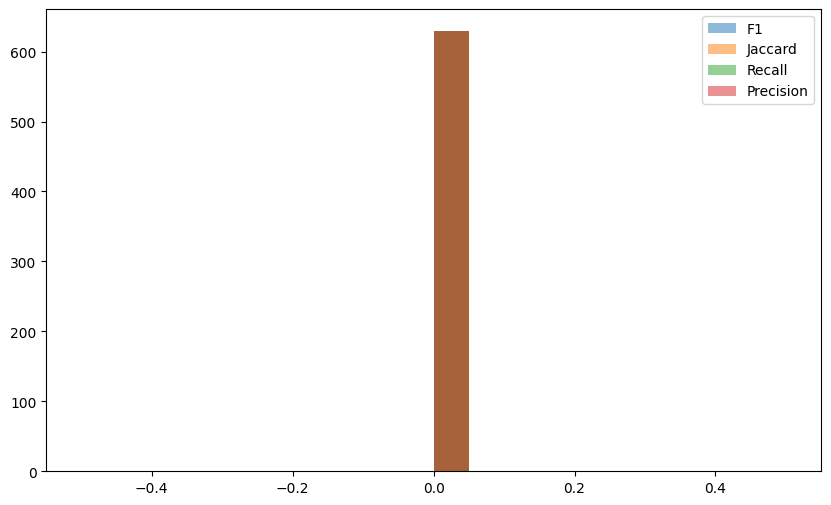

Saved summary to /content/drive/MyDrive/DSP Project/files/summary.csv:
       Metric  Mean  Std Dev
0         F1   0.0      0.0
1    Jaccard   0.0      0.0
2     Recall   0.0      0.0
3  Precision   0.0      0.0


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# -- ensure output folder exists --
out_dir = '/content/drive/MyDrive/DSP Project/files'
os.makedirs(out_dir, exist_ok=True)

# 1) Load evaluation results
df = pd.read_csv(os.path.join(out_dir, 'score.csv'))

# 2) (Optional) Inspect to confirm non-zero values
print(df.head(), '\n', df.dtypes)

# 3) Your plots…
plt.figure(figsize=(10,6))
for m in ['F1','Jaccard','Recall','Precision']:
    plt.hist(df[m], bins=20, alpha=0.5, label=m)
plt.legend(); plt.show()

# 4) Compute & save summary stats
summary = pd.DataFrame({
    'Metric':  ['F1','Jaccard','Recall','Precision'],
    'Mean':    df[['F1','Jaccard','Recall','Precision']].mean().values,
    'Std Dev': df[['F1','Jaccard','Recall','Precision']].std().values
})
summary_path = os.path.join(out_dir, 'summary.csv')
summary.to_csv(summary_path, index=False)
print(f"Saved summary to {summary_path}:\n", summary)


#Plot and Checks